### Automatic Spinal Cord Segmentation Demo

This Jupyter notebook demonstrates how to use SAS Viya to perform medical image analytics. The example illustrates an automatic biomedical image pipeline to segment regions of the image that are the spinal cord. By automatically identifying these spinal cord regions, insights can be made about the patient health and effiency is improved in the clinic. 

In [1]:
import sys, os
import swat as sw
from mayavi import mlab
import numpy as np
import matplotlib
from IPython.display import display
from matplotlib import image as mpimg
import matplotlib.pylab as plt
import pandas as pd
import struct

from importlib import reload
from tabulate import tabulate
%matplotlib inline
from itertools import cycle, islice
import matplotlib.font_manager as fm

from dlpy.network import *
from dlpy.utils import *
from dlpy.applications import *
from dlpy.model import *
from dlpy.images import *
from dlpy.layers import *

### Connect to a server

In [2]:
cashost='localhost'
casport=12125
s = swat.CAS(cashost, casport)
s.loadactionset('image')
s.loadactionset('biomedimage')
s.loadactionset('fedsql')
s.loadactionset('deepLearn')

NOTE: Added action set 'image'.
NOTE: Added action set 'biomedimage'.
NOTE: Added action set 'fedsql'.
NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.021s, user: 0.025s, sys: 0.031s, mem: 1.47mb

In [3]:
demo_path = '<path to the root dir of images and annotations>'
caslib_name = 'demo'
demo_subdir = ''
s.addcaslib(name=caslib_name, path=demo_path, subdirectories=True, datasource='path')

### Function definitions

In [5]:
slides_dir = '<relative path to slides images>'  # Slides
caslib_name = 'casuser'

def load_slides(cas_session, slides_table):
    """Load the slides."""
    casout = s.CASTable(slides_table, replace=True)
    s.image.loadimages(path=slides_dir, caslib='casuser', casout=casout, decode=True)
    fetched_slides = casout[['_resolution_', '_image_', '_path_']].to_frame()
    slide_binaries = fetched_slides['_image_']
    slide_resolutions = fetched_slides['_resolution_']
    slide_paths = fetched_slides['_path_']
    res = np.frombuffer (slide_resolutions[0], np.int64)
    slide_width = res[0]
    slide_height = res[1]
    return slide_binaries, slide_paths, slide_width, slide_height

slide_binaries, slide_paths, slide_width, slide_height = load_slides(s, 'slides')

bar_colors_sc = ['#007477','#a2d3d9']

def plot_volumes_with_ground_truth_sc(volumes, volumes_gt):

    stats = volumes.to_frame()
    stats._minimum_ = (stats._minimum_.astype(int))

    stats_gt = volumes_gt.to_frame()
    stats_gt._minimum_ = (stats_gt._minimum_.astype(int))+1

    joined = pd.concat([stats, stats_gt])
    joined['_content_'] = joined['_content_']/1000000
    qua = joined.pivot(index='_id_', columns='_minimum_', values='_content_')
    plot_bar_chart_with_ground_truth_sc(qua, r'Spinal cord volume ($\mathregular{\times 10^6\ mm^3}$)')

def plot_bar_chart_with_ground_truth_sc(qua, ylabel):
    my_colors = list(islice(cycle(bar_colors_sc), None, len(qua)))
    my_edge_colors = bar_edge_colors
    ax = qua.plot(kind='bar', width=0.75, align='center', color=my_colors, edgecolor=bar_colors_sc)
    for i in range(len(qua.columns)):
        for j in range(len(qua)):
            ax.containers[i][j].set_edgecolor(bar_colors_sc[i])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#2b3138')
    ax.grid(axis='y', color='#2b3138', linestyle=':', alpha=0.3, linewidth=2)
    legend = ax.legend(bbox_to_anchor=(1, 1), prop=ax_ticks_fp)
    legend.get_texts()[0].set_text('Model-predicted')
    legend.get_texts()[1].set_text('Ground truth')

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(fig_width, fig_height)
    plt.xlabel('Patient ID', fontproperties=ax_labels_fp)
    plt.text(0, 1.05, ylabel, fontproperties=ax_labels_fp, transform=ax.transAxes, ha='center', va='center')
    plt.xticks(fontproperties=ax_ticks_fp, rotation='horizontal')
    plt.yticks(fontproperties=ax_ticks_fp)
    plt.tight_layout()
    return ax

bar_edge_colors = ['#007477', '#C96400', '#758c20']
fig_width = 20
fig_height = 10

ax_labels_fp = fm.FontProperties(size=24)
ax_ticks_fp = fm.FontProperties(size=20)

def display_slice_3d(images, dims, ress, fmts, poss, oris, scas, perm, image_index, slice_index, rf, imin=-100, imax=400, additive=0):
    """Display an image slice in 3-D."""
    image = get_image_array(images, dims, ress, fmts, image_index)
    geo_perm = np.zeros(3, dtype=np.int)
    for i in range(3):
        geo_perm[mapping(i)] = mapping(perm[i])
    image = np.transpose(image, perm)
    image = image[slice_index, :, :] + additive
    nr, nc = image.shape[:2]
    dimension = int(dims[image_index])
    pos = np.array(struct.unpack('=%sd' % dimension, poss[image_index]))
    sca = np.array(struct.unpack('=%sd' % dimension, scas[image_index][0:8 * dimension]))
    ori = np.array(struct.unpack('=%sd' % (dimension*dimension), oris[image_index][0:8 * dimension * dimension]))
    xx, yy = np.meshgrid(np.linspace(0, nc, nc), np.linspace(0, nr, nr))
    zz = np.zeros((nr, nc))
    lc = np.vstack((np.reshape(xx, (1, nc*nr)), np.reshape(yy, (1, nc*nr)), np.reshape(zz, (1, nc*nr))))
    ori = np.reshape(ori, (3, 3))
    ori = ori[:, geo_perm]
    sca = sca[geo_perm]
    pos = pos + slice_index * sca[2] * ori[:, 2]
    pos = np.reshape(pos, (3, 1))
    sca = np.diag(sca)
    gc = np.matmul(ori, np.matmul(sca, lc))
    gc = gc + np.matmul(pos, np.ones((1, nc*nr)))
    mlab.mesh(np.reshape(gc[0, :], (nr, nc)), np.reshape(gc[1, :], (nr, nc)), np.reshape(gc[2, :], (nr, nc)),
              scalars = image, colormap='gray', vmin=imin, vmax=imax)
    if (rf):
        for i in range(3):
            clr=((i == 0) * 1, (i == 1) * 1, (i == 2) * 1)
            mlab.quiver3d(pos[0], pos[1], pos[2], ori[0, i], ori[1, i], ori[2, i],
                          line_width=5, scale_factor=50*sca[i, i], color=clr, mode='arrow')
            
def get_image_array_from_row(image_binary, dimension, resolution, myformat, channel_count=1):
    """Get a 3-D image from CAS table row."""
    num_cells = np.prod(resolution)
    if (myformat == '32S'):
        image_array = np.array(struct.unpack('=%si' % num_cells, image_binary[0:4 * num_cells]))
        image_array = np.reshape(image_array, resolution)
    elif myformat == '32F':
        image_array = np.array(struct.unpack('=%sf' % num_cells, image_binary[0:4 * num_cells]))
        image_array = np.reshape(image_array, resolution)
    elif myformat == '64F':
        image_array = np.array(struct.unpack('=%sd' % num_cells, image_binary[0:8 * num_cells]))
        image_array = np.reshape(image_array, resolution)
    elif myformat == '64U':
        image_array = np.array(struct.unpack('=%sQ' % num_cells, image_binary[0:8 * num_cells]))
        image_array = np.reshape(image_array, resolution)
    elif myformat == '16S':
        image_array = np.array(struct.unpack('=%sh' % num_cells, image_binary[0:2 * num_cells]))
        image_array = np.reshape(image_array, resolution)
    elif myformat == '16U':
        image_array = np.array(struct.unpack('=%sH' % num_cells, image_binary[0:2 * num_cells]))
        image_array = np.reshape(image_array, resolution)
    elif myformat == '8U' and channel_count==3:
        image_array = np.array(bytearray(image_binary[0:(num_cells*3)]))
        image_array = np.reshape(image_array, (resolution[0], resolution[1], 3))[:, :, 0:3]
        image_array = reverse(image_array, 2)
    elif myformat == '8S':
        image_array = np.array(struct.unpack('=%sb' % num_cells, image_binary[0:num_cells]))
        image_array = np.reshape(image_array, resolution)
    elif myformat == '8U':
        image_array = np.array(struct.unpack('=%sB' % num_cells, image_binary[0:num_cells]))
        image_array = np.reshape(image_array, resolution)
    else:
        image_array = np.array(bytearray(image_binary))
        image_array = np.reshape(image_array, (resolution[0], resolution[1], 3))
        image_array = reverse(image_array, 2)
    return image_array

def get_image_array(image_binaries, dimensions, resolutions, formats, n, channel_count=1):
    """Get a 3-D image from CAS table."""
    dimension = int(dimensions[n])
    resolution = np.array(struct.unpack('=%sq' % dimension, resolutions[n][0:dimension * 8]))
    resolution = resolution[::-1]
    myformat = formats[n]
    num_cells = np.prod(resolution)
    return get_image_array_from_row(image_binaries[n], dimension, resolution, myformat, channel_count)

def mapping(val):
    """A simple mapping from int to int."""
    if (val == 0):
        return 2
    elif (val == 2):
        return 0
    else:
        return val

def remove_duplicates(array): 
    final_list = [] 
    for num in array: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list

NOTE: Loaded 12 images from /u/coambr/SpinalCordSeg/biomedimage_spinalcord into Cloud Analytic Services table slides.


NOTE: Table SLIDES contains decompressed images.


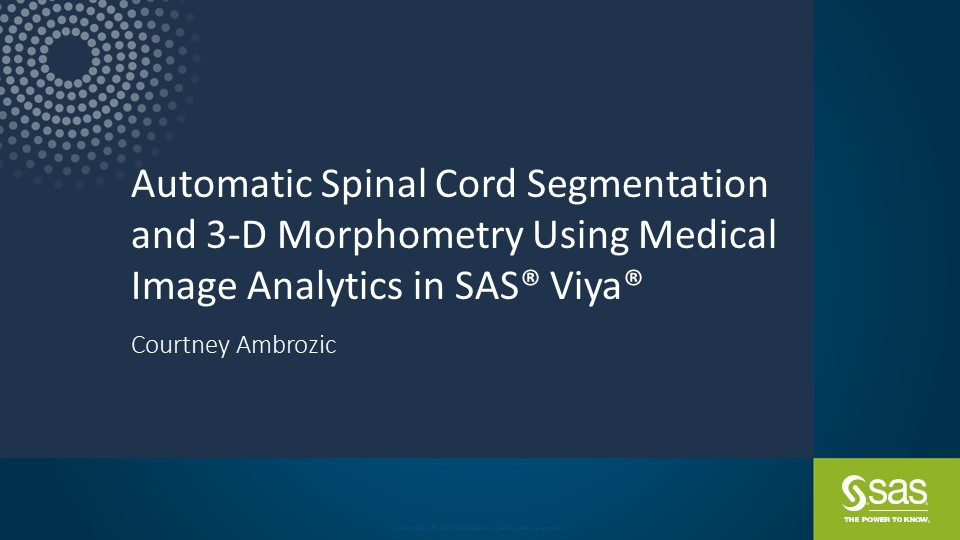

In [25]:
s.image.fetchImages(imageTable = 'slides').Images.Image[0]

NOTE: Table SLIDES contains decompressed images.


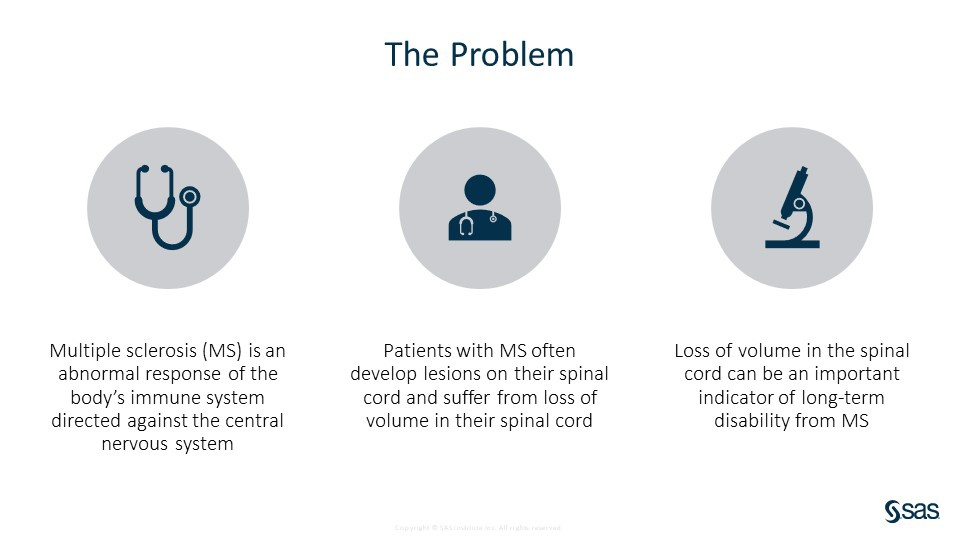

In [26]:
s.image.fetchImages(imageTable = 'slides').Images.Image[1]

NOTE: Table SLIDES contains decompressed images.


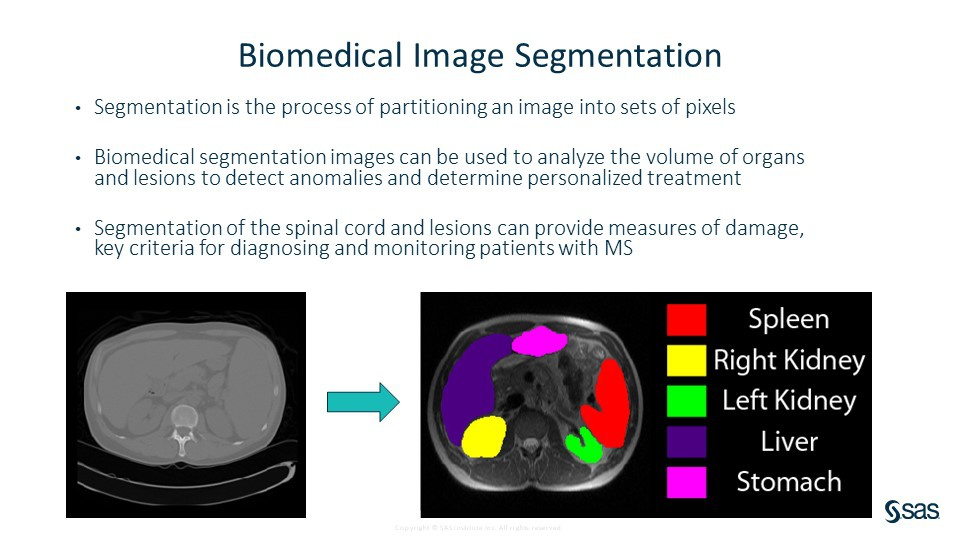

In [27]:
s.image.fetchImages(imageTable = 'slides').Images.Image[2]

NOTE: Table SLIDES contains decompressed images.


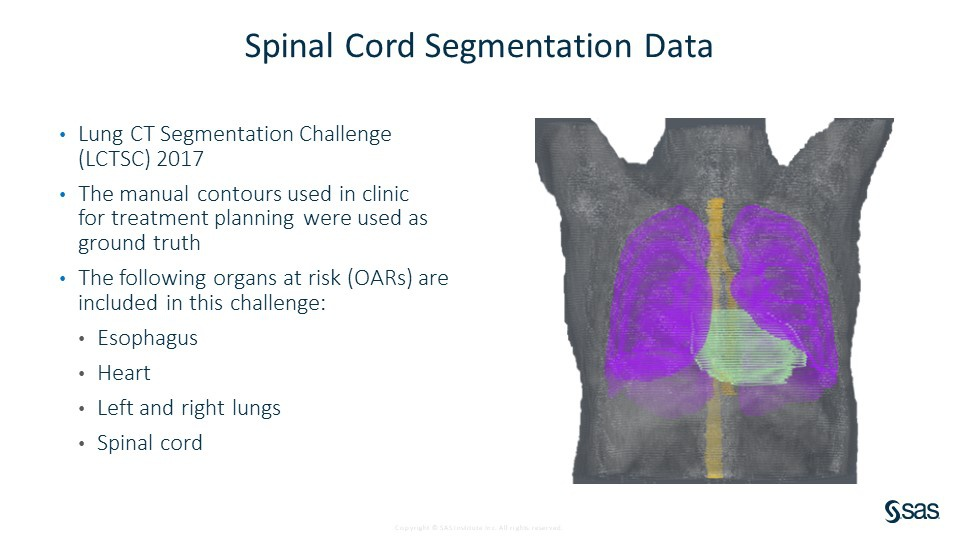

In [28]:
s.image.fetchImages(imageTable = 'slides').Images.Image[3]

Citation:

Yang, J., Sharp, G., Veeraraghavan, H., van Elmpt, W., Dekker, A., Lustberg, T., and Gooding, M. (2017). Data from Lung CT Segmentation Challenge. The Cancer Imaging Archive. DOI: 10.7937/K9/TCIA.2017.3r3fvz08.

Yang, J., Veeraraghavan, H., Armato, S. G., III, Farahani, K., Kirby, J. S., Kalpathy-Kramer, J., van Elmpt, W., Dekker, A., Han, X., Feng, X., Aljabar, P., Oliveira, B., van der Heyden, B., Zamdborg, L., Lam, D., Gooding, M., and Sharp, G. C. (2018). “Autosegmentation for Thoracic Radiation Treatment Planning: A Grand Challenge at AAPM 2017.” Medical Physics 45:4568−4581. DOI: 10.1002/mp.13141.

Clark, K., Vendt, B., Smith, K., Freymann, J., Kirby, J., Koppel, P., Moore, S., Phillips, S., Maffitt, D., Pringle, M., Tarbox, L., and Prior, F. (2013). “The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository.” Journal of Digital Imaging 26:1045−1057. DOI: 10.1007/s10278-013-9622-7.

### Load patient images

In [29]:
imsuid = 'SeriesInstanceUID'
impn = 'PatientName'
imad = 'AcquisitionDate'
impa = 'PatientAge'
impx = 'PatientSex'
allKeysIm = [imsuid, impn, imad, impa, impx]

image = s.CASTable('image', replace=True)
s.image.loadimages(
    path=demo_subdir,
    caslib='bigdisk',
    casout=image,
    addColumns=dict(
        general=['position', 'orientation', 'spacing', 'channeltype', 'width', 'height', 'depth'],
        dicomattributes=dict(keywords=allKeysIm)),
    series=dict(dicom=True),
    recurse=True,
    labellevels=1,
    decode=True
)

NOTE: Loaded 60 images from /bigdisk/lax/coambr/ahhati/LCTSC into Cloud Analytic Services table image.


,casLib,Name,Label,Rows,Columns,casTable
0,CASUSER(coambr),image,,60,21,"CASTable('image', caslib='CASUSER(coambr)')"


### Load DICOM-RT files

In [30]:
patient='PatientID'
image_check='Modality'
rtcsq = 'ROIContourSequence'
rtsuid = 'ReferencedFrameOfReferenceSequence{1}RTReferencedStudySequence{1}RTReferencedSeriesSequence{1}SeriesInstanceUID' 
rtsdesc = 'SeriesDescription'
allKeysRt = [rtsuid, rtcsq, rtsdesc,patient,image_check]
rtdata_points=s.CASTable("rtdata_points",replace=True)
all_colors=s.CASTable("all_colors",replace=True)
fir=True
for j in range(1,6):
    roi1color=('3006_0039_'+str(j)+'_3006_002a')
    organ=('3006_0020_'+str(j)+'_3006_0026')
    allTags = [roi1color,organ]
    s.biomedimage.loaddicomdata(
        path=demo_subdir,
        caslib="bigdisk",
        casOut=rtdata_points,
        addColumns=dict(tags=allTags,keywords=allKeysRt))

    s.table.altertable(table='rtdata_points',
                       columns=[dict(name="_"+roi1color+"_", rename='color'),
                                dict(name="_"+organ+"_", rename='organ')])
    if fir:
        fir=False
        s.fedsql.execdirect("create table all_colors {options replace=true}"
                            "as (select * from rtdata_points)")
    else:
        s.fedsql.execdirect("create table all_colors {options replace=true} "
                            "as (select * from rtdata_points union select * from all_colors)")

NOTE: Loaded 9593 DICOM data row(s) from path ahhati/LCTSC into table rtdata_points.
NOTE: Table ALL_COLORS was created in caslib CASUSER(coambr) with 9593 rows returned.
NOTE: Loaded 9593 DICOM data row(s) from path ahhati/LCTSC into table rtdata_points.
NOTE: Table ALL_COLORS was created in caslib CASUSER(coambr) with 9653 rows returned.
NOTE: Loaded 9593 DICOM data row(s) from path ahhati/LCTSC into table rtdata_points.
NOTE: Table ALL_COLORS was created in caslib CASUSER(coambr) with 9713 rows returned.
NOTE: Loaded 9593 DICOM data row(s) from path ahhati/LCTSC into table rtdata_points.
NOTE: Table ALL_COLORS was created in caslib CASUSER(coambr) with 9773 rows returned.
NOTE: Loaded 9593 DICOM data row(s) from path ahhati/LCTSC into table rtdata_points.
NOTE: Table ALL_COLORS was created in caslib CASUSER(coambr) with 9833 rows returned.


NOTE: Table SLIDES contains decompressed images.


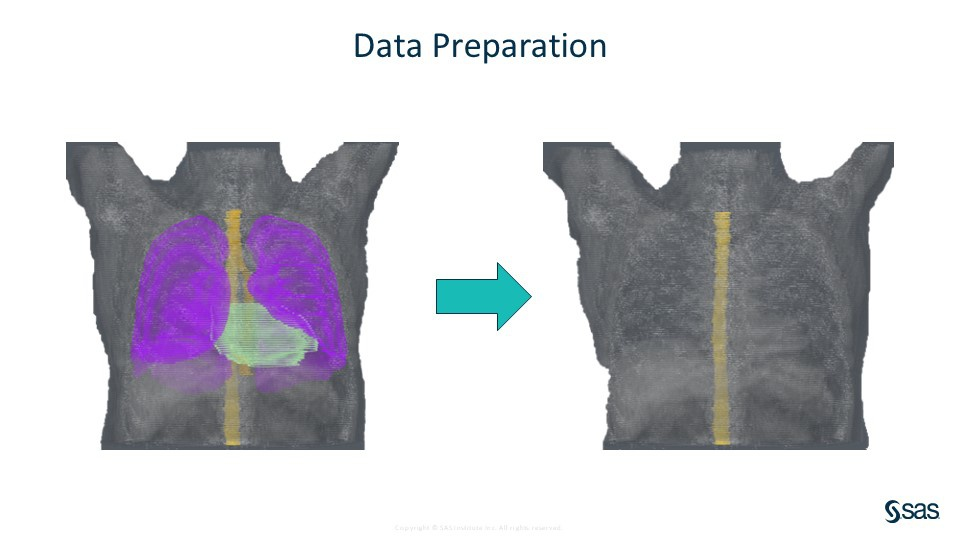

In [31]:
s.image.fetchImages(imageTable = 'slides').Images.Image[4]

### Determine colors of the spinal cord for each image

In [32]:
s.fedsql.execdirect("""create table imrt {options replace=true} as (select a._id_, a._ROIContourSequence_, 
                       a._PatientId_, a.color, a.organ, b._image_, b._dimension_, b._resolution_, b._imageformat_, 
                       b._position_, b._orientation_, b._spacing_, b._PatientName_, a._SeriesDescription_, b._id_ 
                       as rtid, b._label_ from all_colors as a _hash_ inner join image as b on 
                       b._SeriesInstanceUID_=a._ReferencedFrameOfReferenceSequence_1_RTReferencedStudySequence_1_RTReferencedSeriesSequence_1_SeriesInstanceUID_
                       WHERE a.organ='SpinalCord')""")

NOTE: Table IMRT was created in caslib CASUSER(coambr) with 60 rows returned.


+ Elapsed: 237s, user: 231s, sys: 65.5s, mem: 4.15e+04mb

In [33]:
imrt=s.CASTable("imrt",replace=True)
cols=imrt[["color"]].values

spinal_cord_colors=remove_duplicates(cols)

for i in spinal_cord_colors:
    roidisplaycolor=i[0]
    print(roidisplaycolor)

255\0\0
242\202\48
0\0\255
255\0\255
255\255\0
34\139\34
255\99\71
0\240\0
165\80\65
200\180\255


### Create mask images

In [ ]:
first = True
for colors in spinal_cord_colors:
    imrt=s.CASTable("imrt",replace=True)
    imrt2=s.CASTable("imrt2",replace=True)
    string="color like '"+ colors[0] + "'"
    tmpTable=imrt.query(string)
    s.partition(table=tmpTable, casout=imrt2)
    s.biomedimage.processbiomedimages(images=dict(table=imrt2),
                                      steps=[dict(stepparameters=dict(steptype='roi2mask',
                                                                      roi2maskparameters=dict(roi2masktype='dicomrt_specific',
                                                                                              roicontoursequence='_ROIContourSequence_',
                                                                                              correctionsensitivity=.25,
                                                                                              pixelintensity=255,
                                                                                              outputbackground=0,
                                                                                              roidisplaycolor=colors[0]))),
                                             dict(stepParameters=dict(stepType='rescale', rescaleparameters=dict(rescaleType="channeltype_8u")))],
                                      casout=dict(name='masks_all', replace=True),
                                      decode=True,
                                      copyvars=['_id_', 'color', 'RTID', '_label_'])
    if (first):
        first = False
        s.fedsql.execdirect("create table pdata {options replace=true}"
                            "as (select * from masks_all)")
    else:
        s.fedsql.execdirect("create table pdata {options replace=true}"
                            "as (select * from masks_all union select * from pdata)")
        
pdata=s.CASTable("pdata",replace=True)

### Export to 2-D and merge

In [42]:
s.biomedimage.processbiomedimages(images=dict(table=pdata),
                                  steps=[dict(stepparameters=dict(steptype='clamp', clampParameters=dict(clampType='basic',high=1.0,low=0.0))),
                                         dict(stepparameters=dict(steptype='rescale', rescaleParameters=dict(rescaleType='channeltype_8u', min=0, max=1))),
                                         dict(stepparameters=dict(steptype='export', encodetype='png'))],
                                  decode=True,
                                  copyvars=['rtid','_id_','_label_'],
                                  casout=dict(name='masks_2d', replace=True)
                                 )

images_working_2d=s.CASTable('image', replace=True)
images_2d=s.CASTable('images_2d', replace=True)
s.biomedimage.processbiomedimages(images=dict(table=images_working_2d),
                                  steps=[dict(stepparameters=dict(steptype='export', encodetype='png'))],
                                  copyvars=['_id_','_label_'],
                                  decode=True,
                                  casout=images_2d)

s.table.altertable(table='masks_2d', columns=[dict(name='_image_', rename='seg')])

s.fedsql.execdirect("""create table merged_im {options replace=true} as (select a._id_, a.seg, b._image_, a._bioMedId_, 
                       a._bioMedDimension_, a._sliceIndex_, b._label_, b._id_ as rtid from masks_2d as a _hash_ 
                       inner join images_2d as b on b._label_=a._label_ and a._sliceIndex_=b._sliceIndex_)""")

NOTE: Processed 60 images from Cloud Analytic Services table PDATA.
NOTE: Processed 60 images from Cloud Analytic Services table IMAGE.
NOTE: Table MERGED_IM was created in caslib CASUSER(coambr) with 9533 rows returned.


+ Elapsed: 33.7s, user: 55.7s, sys: 18.1s, mem: 3.15e+03mb

### Define subsets

In [43]:
image_subs={
"LCTSC-Test-S1-101":[1, 104],
"LCTSC-Test-S1-102":[1, 112],
"LCTSC-Test-S1-103":[30, 118],
"LCTSC-Test-S1-104":[1, 35],
"LCTSC-Test-S1-201":[1, 25],
"LCTSC-Test-S1-202":[1, 23],
"LCTSC-Test-S1-203":[18, 40],
"LCTSC-Test-S1-204":[4, 30],
"LCTSC-Test-S2-101":[1, 47],
"LCTSC-Test-S2-102":[12, 52],
"LCTSC-Test-S2-103":[2, 12],
"LCTSC-Test-S2-104":[1, 29],
"LCTSC-Test-S2-201":[2, 25],
"LCTSC-Test-S2-202":[6, 16],
"LCTSC-Test-S2-203":[2, 29],
"LCTSC-Test-S2-204":[10, 38],
"LCTSC-Test-S3-101":[59, 84],
"LCTSC-Test-S3-102":[46, 50],
"LCTSC-Test-S3-103":[41, 97],
"LCTSC-Test-S3-104":[43, 72],
"LCTSC-Test-S3-201":[66, 70],
"LCTSC-Test-S3-202":[1, 98],
"LCTSC-Test-S3-203":[44, 46],
"LCTSC-Test-S3-204":[1, 155],
"LCTSC-Train-S1-001":[1, 140],
"LCTSC-Train-S1-002":[12, 131],
"LCTSC-Train-S1-003":[1, 127],
"LCTSC-Train-S1-004":[1, 25],
"LCTSC-Train-S1-005":[1, 81],
"LCTSC-Train-S1-006":[1, 108],
"LCTSC-Train-S1-007":[3, 124],
"LCTSC-Train-S1-008":[1, 24],
"LCTSC-Train-S1-009":[1, 121],
"LCTSC-Train-S1-010":[1, 26],
"LCTSC-Train-S1-011":[1, 117],
"LCTSC-Train-S1-012":[1,29],
"LCTSC-Train-S2-001":[6, 39],
"LCTSC-Train-S2-002":[4, 45],
"LCTSC-Train-S2-004":[19, 31],
"LCTSC-Train-S2-005":[10, 58],
"LCTSC-Train-S2-006":[1,25 ],
"LCTSC-Train-S2-007":[7, 27],
"LCTSC-Train-S2-008":[2,40],
"LCTSC-Train-S2-009":[10, 45],
"LCTSC-Train-S2-010":[1, 27],
"LCTSC-Train-S2-011":[2, 41],
"LCTSC-Train-S2-012":[6, 39],
"LCTSC-Train-S3-001":[1, 53],
"LCTSC-Train-S3-002":[1, 41],
"LCTSC-Train-S3-003":[50, 88],
"LCTSC-Train-S3-004":[55, 201],
"LCTSC-Train-S3-005":[1, 52],
"LCTSC-Train-S3-006":[18, 35],
"LCTSC-Train-S3-007":[1, 47],
"LCTSC-Train-S3-008":[1, 119],
"LCTSC-Train-S3-009":[1, 55],
"LCTSC-Train-S3-010":[22, 48],
"LCTSC-Train-S3-011":[6, 97],
"LCTSC-Train-S3-012":[3, 18]
}

merged_im=s.CASTable('merged_im', replace=True)
image_subset = s.CASTable('image_subset', replace=True)
subsets = s.CASTable('subsets', replace=True)

first=True
for i in image_subs.keys():
    tmpTable=merged_im.query("_label_ = '"+i+"' and _sliceIndex_ >= " 
                      + str(image_subs[i][0]-1) + " and _sliceIndex_ <= " 
                       + str(image_subs[i][1]-1),inplace =False)
    s.partition(table=tmpTable, casout=subsets)
    if (first):
        first = False
        s.fedsql.execdirect("create table image_subset {options replace=true} as (select * from subsets)")
    else:
        s.fedsql.execdirect("create table image_subset {options replace=true} as (select * from subsets union select * from image_subset)")

NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 104 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 216 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 305 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 340 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 365 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 388 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 411 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 438 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 485 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 526 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 537 rows returned.
NOTE: Table IMAGE_SUBSET was created in cas

### Split into training, validation, and testing data
* <span style="font-size:larger;"> **training** 36 images
* <span style="font-size:larger;"> **validation** 7 images
* <span style="font-size:larger;"> **test** 17 images

NOTE: Table SLIDES contains decompressed images.


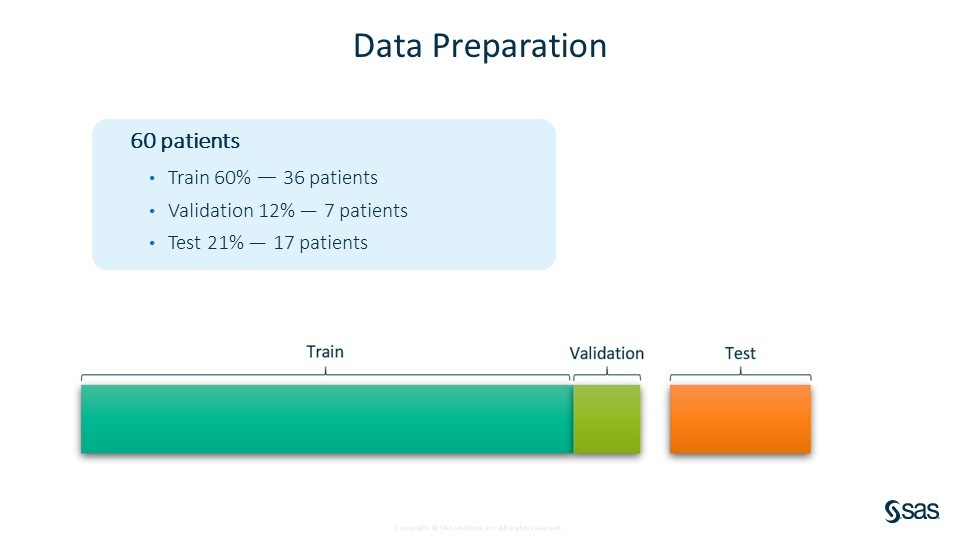

In [12]:
s.image.fetchImages(imageTable = 'slides').Images.Image[5]

In [44]:
s.fedsql.execdirect("create table merged_im {options replace=true} as (select * from image_subset)")

merged_im = s.CASTable('merged_im', replace=True)

train = s.CASTable('train', replace=True)
test = s.CASTable('test', replace=True)
validation = s.CASTable('validation', replace=True)

tmpTable=merged_im.query("_label_ like '%Train%'")
s.partition(table=tmpTable, casout=train)

cvdata=("'LCTSC-Test-S1-101'"+","+
        "'LCTSC-Test-S1-102'"+","+
        "'LCTSC-Test-S1-202'"+","+
        "'LCTSC-Test-S2-103'"+","+
        "'LCTSC-Test-S2-204'"+","+
        "'LCTSC-Test-S3-101'"+","+
        "'LCTSC-Test-S3-202'"
       )

tmpTable=merged_im.query("_label_ like '%Test%' and _label_ not in ("+cvdata+") ")
s.partition(table=tmpTable, casout=test)

tmpTable=merged_im.query("_label_ in ("+cvdata+")")
s.partition(table=tmpTable, casout=validation)

NOTE: Table MERGED_IM was created in caslib CASUSER(coambr) with 3143 rows returned.


[caslib]

 'CASUSER(coambr)'

[tableName]

 'VALIDATION'

[rowsTransferred]

 0

[shuffleWaitTime]

 0.0

[minShuffleWaitTime]

 1e+300

[maxShuffleWaitTime]

 0.0

[averageShuffleWaitTime]

 0.0

[casTable]

 CASTable('VALIDATION', caslib='CASUSER(coambr)')

+ Elapsed: 0.697s, user: 0.675s, sys: 0.397s, mem: 287mb

NOTE: Table SLIDES contains decompressed images.


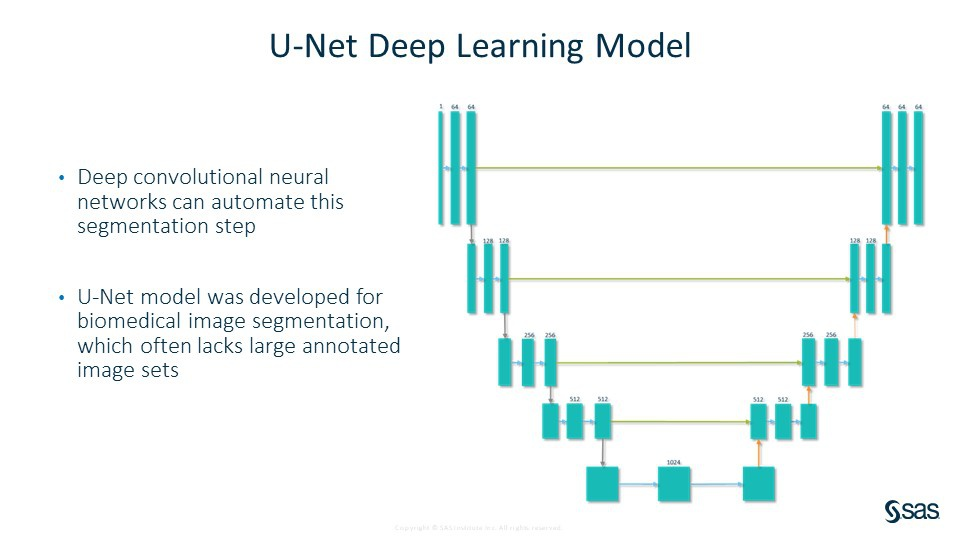

In [12]:
s.image.fetchImages(imageTable = 'slides').Images.Image[6]

### Create U-Net model

In [9]:
img_size=512

init=None
factor = 512/img_size
factor2 = 1

# 512 to 256
inputs = Input(1, 512/factor, 512/factor, scale = 1.0 / 255, name='data')
conv1 = Conv2d(64*factor2, 3, act = 'relu', init=init, include_bias=True)(inputs)
conv1 = Conv2d(64*factor2, 3, act = 'relu', init=init, include_bias=True)(conv1)
pool1 = Pooling(2)(conv1)

# 256 to 128
conv2 = Conv2d(128*factor2, 3, act = 'relu', init=init, include_bias=True)(pool1)
conv2 = Conv2d(128*factor2, 3, act = 'relu', init=init, include_bias=True)(conv2)
pool2 = Pooling(2)(conv2)

# 128 to 64
conv3 = Conv2d(256*factor2, 3, act = 'relu', init=init, include_bias=True)(pool2)
conv3 = Conv2d(256*factor2, 3, act = 'relu', init=init, include_bias=True)(conv3)
pool3 = Pooling(2)(conv3)

# 64 to 32
conv4 = Conv2d(512*factor2, 3, act = 'relu', init=init, include_bias=True)(pool3)
conv4 = Conv2d(512*factor2, 3, act = 'relu', init=init, include_bias=True)(conv4)
pool4 = Pooling(2)(conv4) 

# 32
conv5 = Conv2d(1024*factor2, 3, act = 'relu', init=init, include_bias=True)(pool4)
conv5 = Conv2d(1024*factor2, 3, act = 'relu', init=init, include_bias=True)(conv5)

# 32 to 64
tconv6 = Transconvo(512*factor2, 3, stride = 2, act='relu', padding = 1, output_size = (64/factor, 64/factor, 512*factor2), init=init)(conv5)  
# 64
merge6 = Concat()([conv4, tconv6])
conv6 = Conv2d(512*factor2, 3, act = 'relu', init=init)(merge6)
conv6 = Conv2d(512*factor2, 3, act = 'relu', init=init)(conv6)

# 64 to 128
tconv7 = Transconvo(256*factor2,3, stride = 2, act='relu', padding = 1, output_size = (128/factor, 128/factor, 256*factor2), init=init)(conv6)  # 128
#merge7 = Concat(src_layers = [conv3, tconv7])
merge7 = Concat()([conv3, tconv7])
conv7 = Conv2d(256*factor2, 3, act = 'relu', init=init)(merge7)
conv7 = Conv2d(256*factor2, 3, act = 'relu', init=init)(conv7)

# 128 to 256
tconv8 = Transconvo(128*factor2, 3, stride = 2, act='relu', padding = 1, output_size = (256/factor, 256/factor, 128*factor2), init=init)(conv7)  # 256
merge8 = Concat()([conv2, tconv8])
conv8 = Conv2d(128*factor2, 3, act = 'relu', init=init)(merge8)
conv8 = Conv2d(128*factor2, 3, act = 'relu', init=init)(conv8)

# 256 to 512
tconv9 = Transconvo(64*factor2, 3, stride = 2, act='relu', padding = 1, output_size = (512/factor, 512/factor, 64*factor2), init=init)(conv8)  # 512
merge9 = Concat()([conv1, tconv9])
conv9 = Conv2d(64*factor2, 3, act = 'relu', init=init)(merge9)
conv9 = Conv2d(64*factor2, 3, act = 'relu', init=init)(conv9)

conv10 = Conv2d(2, 3, act = 'relu', init=init)(conv9)

seg1 = Segmentation(name='Segmentation_1', targetscale=1.0/255, nchannels=1, error='entropy',  outputImageType='PNG')(conv10)

model = Model(s, inputs = inputs, outputs = seg1)
model.compile()

model.print_summary()
model.model_name

NOTE: Model compiled successfully.


'Model_QVLyv8'

### Define training parameters

In [14]:
solver = AdamSolver(lr_scheduler=StepLR(learning_rate=0.0001, step_size=30, gamma=0.9), 
                    clip_grad_max = 100, 
                    clip_grad_min = -100)

optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=1, 
                      log_level=2, 
                      max_epochs=50, 
                      reg_l2=0.0001, 
                      seed=13309)

dataspecs=[dict(type='image', layer='data', data=['_image_']),
           dict(type='image', layer='Segmentation_1', data=['seg'])]

The following argument(s) learning_rate, learning_rate_policy, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


### Fit the model

In [9]:
model.fit(data='train',
          valid_table='validation',
          optimizer=optimizer, 
          data_specs=dataspecs, 
          n_threads=32, 
          record_seed=54321,
          force_equal_padding=True,
          save_best_weights=True, 
          gpu=dict(devices=[0,1])
          )

NOTE: Training from scratch.
NOTE: Using sysgpu01.unx.sas.com: 2 out of 4 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 34513282.
NOTE:  The approximate memory cost is 52318.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost      66.79 (s).
NOTE:  The total number of threads on each worker is 32.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  0        0.0001       3.063e+04    0.01069             1342         0.000698   322.00
NOTE:  1        0.0001            1425  0.0007528             1096         0.000698   294.17
NOTE:  2        0.0001            1173  0.0007556            937.2         0.000698   296.13

,Descr,Value
0,Model Name,model_rkhyra
1,Model Type,Convolutional Neural Network
2,Number of Layers,33
3,Number of Input Layers,1
4,Number of Output Layers,0
5,Number of Convolutional Layers,19
6,Number of Pooling Layers,4
7,Number of Fully Connected Layers,0
8,Number of Concatenation Layers,4
9,Number of Transpose Convolution Layers,4


### Load weights

In [10]:
#weights_path = 'path to weights and attributes'
weights_path = '/bigdisk/lax/coambr/spinal_cord_model_weights'
s.dropcaslib('bigdisk')

model.load_weights(weights_path+'/Model_RKHYrA_weights.sashdat')
model.load_weights_attr(weights_path+'/Model_RKHYrA_weights_attr.sashdat')

NOTE: Cloud Analytic Services removed the caslib 'bigdisk'.
NOTE: Model weights attached successfully!
NOTE: Model_RKHYrA_weights_attr.sashdat is used as weigths attribute.
NOTE: Model attributes attached successfully!
NOTE: Model attributes attached successfully!


ERROR: An attribute with key 'target' already exists for column '    ' in attribute set 'dl_input_parms' of table 'MODEL_QVLYV8_WEIGHTS'.
ERROR: The action stopped due to errors.


### Predict segmentation for test set

In [15]:
s.dlscore(modeltable=model.model_name, 
          initWeights=model.model_weights, 
          table='test', 
          gpu={"devices":[2,3]},
          copyVars=['seg', '_label_', '_sliceIndex_', '_bioMedId_', '_id_','_image_','_bioMedDimension_'],
          casout=dict(name='output', replace=True))

NOTE: Using dlgrd009.unx.sas.com: 2 out of 4 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           634
 1  Number of Observations Used           634
 2  Misclassification Error (%)       0.01653
 3           Pixel Accuracy (%)      99.98352
 4            Mean Accuracy (%)      96.44321
 5                 Mean IoU (%)      90.63172
 6   Frequency Weighted IoU (%)      99.96906
 7                   Loss Error      126.5566

[OutputCasTables]

             casLib    Name  Rows  Columns  \
 0  CASUSER(coambr)  output   634       12   
 
                                        casTable  
 0  CASTable('output', caslib='CASUSER(coambr)')  

+ Elapsed: 42.4s, user: 19.9s, sys: 11.1s, mem: 1.61e+04mb

### Threshold the predicted images

In [16]:
s.fedsql.execdirect("create table threshold {options replace=true} as (select * from output)")

s.table.altertable(table='threshold',columns=[dict(name="_image_", rename='origimage'), 
                                           dict(name="_DL_PredImg_", rename='_image_'),
                                           dict(name="seg", rename='gt_seg')])

s.image.processImages(
    casout=dict(name='imgsOut', replace=True),
    imagefunctions=[
        {'options':{
            'functiontype':'THRESHOLD',
            'type':'TRUNCATE',
            'value':1}}],
    decode=False,
    copyVars=['_sliceIndex_','origimage','gt_seg','_bioMedDimension_','_bioMedId_'],
    table={'name':'threshold'},
)

NOTE: Table THRESHOLD was created in caslib CASUSER(coambr) with 634 rows returned.
NOTE: Table THRESHOLD contains compressed images.
NOTE: 634 out of 634 images were processed successfully and saved as compressed images to the Cloud Analytic Services table imgsOut.


,casLib,Name,Label,Rows,Columns,casTable
0,CASUSER(coambr),imgsOut,,634,8,"CASTable('imgsOut', caslib='CASUSER(coambr)')"


### Annotate images

In [17]:
s.fedsql.execdirect("create table annotated {options replace=true} as (select * from imgsOut)")

s.image.annotateimages(images=dict(table='annotated', image='origimage'),
                       annotations=[
                           dict(annotationparameters=
                                dict(annotationtype='segmentation',
                                    image='gt_seg',
                                    colorMap='cool',
                                    transparency=50,
                                    inputbackground=0
                                    )),
                            dict(annotationparameters=
                                dict(annotationtype='segmentation',
                                    image='_image_',
                                    colorMap='hsv',
                                    transparency=50,
                                    inputbackground=0
                                    ))],
                       copyVars=['_sliceIndex_', '_label_'],
                       casout=dict(name='overlay', replace=True))

NOTE: Table ANNOTATED was created in caslib CASUSER(coambr) with 634 rows returned.
NOTE: 634 of 634 images were processed successfully and saved as encoded images to the Cloud Analytic Services table overlay.


,casLib,Name,Label,Rows,Columns,casTable
0,CASUSER(coambr),overlay,,634,4,"CASTable('overlay', caslib='CASUSER(coambr)')"


NOTE: Table OVERLAY contains compressed images.


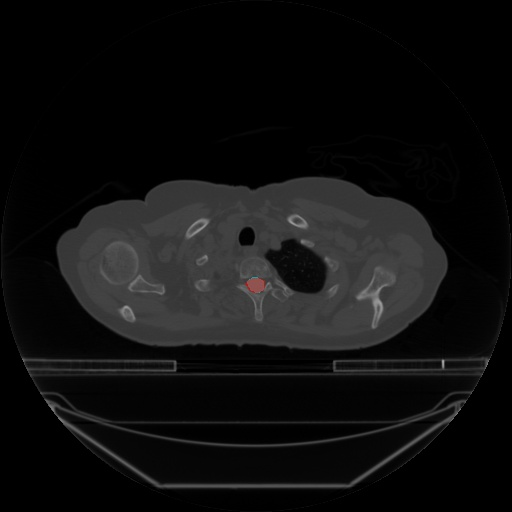

NOTE: Table OVERLAY contains compressed images.


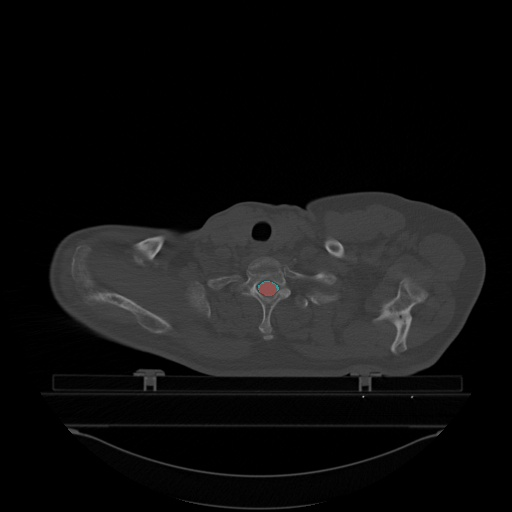

NOTE: Table OVERLAY contains compressed images.


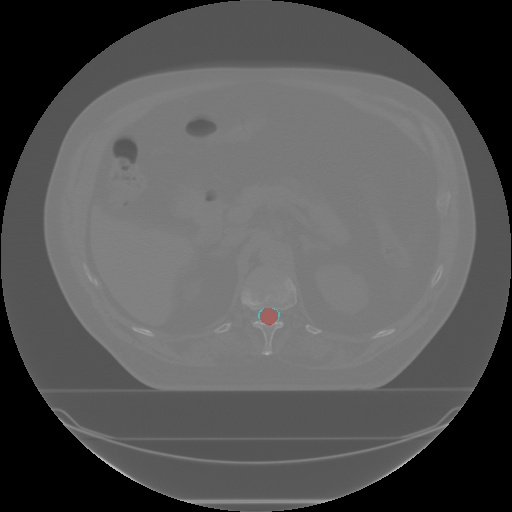

In [18]:
display(s.image.fetchimages(table='overlay', to=200).Images['Image'][15])
display(s.image.fetchimages(table='overlay', to=200).Images['Image'][20])
display(s.image.fetchimages(table='overlay', to=200).Images['Image'][25])

### Get decoded geometry info from CT scans

In [9]:
expname = 'LCTSC-Test-S3-204'
single_image_query = "_label_='"+expname+"'"
image_rows = s.CASTable('image').query(single_image_query).to_frame()

image_dims = image_rows["_dimension_"]
image_fmts = image_rows["_channelType_"]
image_images = image_rows["_image_"]
image_ress = image_rows["_resolution_"]
image_scas = image_rows["_spacing_"]
image_poss = image_rows["_position_"]
image_oris = image_rows["_orientation_"]
image_id = image_rows["_id_"]

# Import ground truth test set back into 3-D
test = s.CASTable('test', replace=True)
tmpTable=test.query("_label_ like 'LCTSC-Test-S3-204'")
ground_truth_seg = s.CASTable('ground_truth_seg', replace=True)
s.partition(table=tmpTable, casout=dict(name='ground_truth_seg', replace=True))

[caslib]

 'CASUSER(coambr)'

[tableName]

 'GROUND_TRUTH_SEG'

[rowsTransferred]

 0

[shuffleWaitTime]

 0.0

[minShuffleWaitTime]

 1e+300

[maxShuffleWaitTime]

 0.0

[averageShuffleWaitTime]

 0.0

[casTable]

 CASTable('GROUND_TRUTH_SEG', caslib='CASUSER(coambr)')

+ Elapsed: 0.181s, user: 0.131s, sys: 0.075s, mem: 109mb

### Import the images back into 3-D

In [8]:
test_import = s.CASTable('test_import', replace=True)

s.biomedimage.processbiomedimages(
    images=dict(table=dict(name="test"), image='seg'),
    steps=[dict(stepparameters=dict(steptype='import',targetDimension=3))],
    copyvars={"_label_","_id_", '_bioMedId_'},
    casout=test_import)

# Rename image column within the table
s.table.altertable(table='test_import',
                   columns=[dict(name='_image_', rename='seg')])

final_images_predicted_import_total = s.CASTable('final_images_predicted_import_total', replace=True)

s.biomedimage.processbiomedimages(
    images=dict(table=dict(name="imgsOut")),
    steps=[dict(stepparameters=dict(steptype='import',targetDimension=3))],
    copyvars={"_label_","_id_", '_bioMedId_'},
    casout=final_images_predicted_import_total)

NOTE: Processed 634 images from Cloud Analytic Services table TEST.
NOTE: Processed 634 images from Cloud Analytic Services table IMGSOUT.


,casLib,Name,Label,Rows,Columns,casTable
0,CASUSERHDFS(coambr),final_images_predicted_import_total,,17,5,CASTable('final_images_predicted_import_total'...


NOTE: Table SLIDES contains decompressed images.


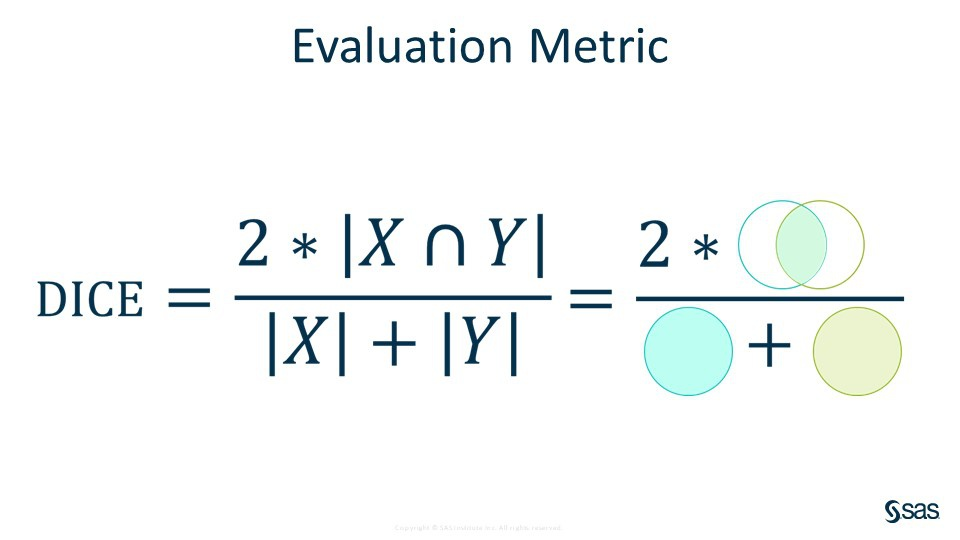

In [16]:
s.image.fetchImages(imageTable = 'slides').Images.Image[8]

### Compute the Dice score

In [13]:
# Merge the two tables
merged = s.CASTable('merged')
s.fedsql.execdirect("create table merged {options replace=true} as "
                        "select a.*, b._image_ "
                        "from test_import as a inner join final_images_predicted_import_total as b "
                        "on a._label_=b._label_ ")

# Compute the Dice score
quantities = s.CASTable(name='quantities', replace=True)
s.biomedimage.quantifybiomedimages(images=dict(table=merged),
                                   quantities=[dict(quantityparameters=dict(quantitytype='dice', image='seg'))],
                                   region='image',
                                   copyvars=['_id_', '_label_'],
                                   casout=quantities)

quantities_output = quantities.to_frame()

NOTE: Table MERGED was created in caslib CASUSERHDFS(coambr) with 17 rows returned.
NOTE: Processed 17 images from Cloud Analytic Services table MERGED.


In [14]:
quantities_output

,_imageId_,_dice_,_id_,_label_
0,683,0.841331,683,LCTSC-Test-S1-201
1,1293,0.858157,1293,LCTSC-Test-S2-104
2,1438,0.808137,1438,LCTSC-Test-S2-201
3,1575,0.754615,1575,LCTSC-Test-S2-202
4,1718,0.795561,1718,LCTSC-Test-S2-203
5,433,0.904882,433,LCTSC-Test-S1-103
6,565,0.870075,565,LCTSC-Test-S1-104
7,955,0.870454,955,LCTSC-Test-S2-101
8,2055,0.625164,2055,LCTSC-Test-S3-102
9,7399,0.884752,7399,LCTSC-Test-S1-203


In [15]:
quantities_output['_dice_'].mean()

0.8007619203097439

In [29]:
final_segs = s.CASTable('final_segs', replace=True)
s.biomedimage.processbiomedimages(
    images=dict(table=dict(name="ground_truth_seg"), image='seg'),
    steps=[dict(stepparameters=dict(steptype='import', targetDimension=3))],
    decode=True,
    copyVars=['_id_', '_label_'],
    casout=final_segs
)

final_testim = s.CASTable('final_testim', replace=True)
s.biomedimage.processbiomedimages(
    images=dict(table=dict(name="test")),
    steps=[dict(stepparameters=dict(steptype='import', targetDimension=3))],
    decode=True,
    copyVars=['_id_', '_label_'],
    casout=final_testim
)

# Import predicted images into 3-D
import_images = s.CASTable('import_images', replace=True)
s.biomedimage.processbiomedimages(
    images=dict(table=dict(name="imgsOut")),
    steps=[dict(stepparameters=dict(steptype='import', targetDimension=3))],
    decode=True,
    copyVars=['_id_', '_label_'],
    casout=import_images
)

import_images_geo = s.CASTable('import_images_geo')
s.fedsql.execdirect("""create table import_images_geo {options replace=true} as select a.*, b._position_, b._orientation_, 
                    b._spacing_ from import_images as a inner join image as b on a._label_=b._label_""")

tmpTable=import_images_geo.query("_label_ like 'LCTSC-Test-S3-204'")
single_import_image = s.CASTable('single_import_image', replace=True)
s.partition(table=tmpTable, casout=dict(name='single_import_image', replace=True))

NOTE: Processed 155 images from Cloud Analytic Services table GROUND_TRUTH_SEG.
NOTE: Processed 634 images from Cloud Analytic Services table TEST.
NOTE: Processed 634 images from Cloud Analytic Services table IMGSOUT.
NOTE: Table IMPORT_IMAGES_GEO was created in caslib CASUSER(coambr) with 17 rows returned.


[caslib]

 'CASUSER(coambr)'

[tableName]

 'SINGLE_IMPORT_IMAGE'

[rowsTransferred]

 0

[shuffleWaitTime]

 0.0

[minShuffleWaitTime]

 1e+300

[maxShuffleWaitTime]

 0.0

[averageShuffleWaitTime]

 0.0

[casTable]

 CASTable('SINGLE_IMPORT_IMAGE', caslib='CASUSER(coambr)')

+ Elapsed: 0.622s, user: 0.411s, sys: 0.235s, mem: 326mb

### Build surfaces for ground truth and predicted segmentations

In [30]:
# Build predicted image surface
verticesMasked = s.CASTable('verticesMasked', replace=True)
facesMasked = s.CASTable('facesMasked', replace=True)
s.biomedimage.buildsurface(images=dict(table=single_import_image),
                           thresholds=[dict(low=1, high=1000)],
                           smoothing=dict(iterations=3),
                           outputvertices=verticesMasked,
                           outputfaces=facesMasked
                          )


fetchedVertices=verticesMasked.to_frame()
fetchedFaces=facesMasked.to_frame()

x = fetchedVertices.loc[:, ["_x_"]]
y = fetchedVertices.loc[:, ["_y_"]]
z = fetchedVertices.loc[:, ["_z_"]]
flist = fetchedFaces.loc[:, ["_v1_", "_v2_", "_v3_"]]

rgb = (255, 0, 0)
op = 0.50

NOTE: Processed 1 image from Cloud Analytic Services table SINGLE_IMPORT_IMAGE.


In [31]:
# Build ground truth image surface
final_segs_geo = s.CASTable('final_segs_geo')

s.fedsql.execdirect("""create table final_segs_geo {options replace=true} as select a.*, b._position_, b._orientation_, 
                    b._spacing_ from final_segs as a inner join image as b on a._label_=b._label_""")

vertices_seg = s.CASTable('vertices_seg', replace=True)
faces_seg = s.CASTable('faces_seg', replace=True)
s.biomedimage.buildsurface(images=dict(table=final_segs_geo),
                           thresholds=[dict(low=1, high=1000)],
                           smoothing=dict(iterations=3),
                           outputvertices=vertices_seg,
                           outputfaces=faces_seg)

fetchedVertices=vertices_seg.to_frame()
fetchedFaces=faces_seg.to_frame()

xs = fetchedVertices.loc[:, ["_x_"]]
ys= fetchedVertices.loc[:, ["_y_"]]
zs = fetchedVertices.loc[:, ["_z_"]]
flists = fetchedFaces.loc[:, ["_v1_", "_v2_", "_v3_"]]

rgbs = (0, 255, 0)
ops = 0.75

NOTE: Table FINAL_SEGS_GEO was created in caslib CASUSER(coambr) with 1 rows returned.
NOTE: Processed 1 image from Cloud Analytic Services table FINAL_SEGS_GEO.


### Display spinal cord segmentation results in 3-D

In [32]:
mlab.triangular_mesh(xs, ys, zs, flists, color=tuple([c/255 for c in rgbs]),opacity=ops)
mlab.triangular_mesh(x, y, z, flist, color=tuple([c/255 for c in rgb]),opacity=op)
display_slice_3d(image_images, image_dims, image_ress, image_fmts, image_poss,image_oris,image_scas,(0, 1, 2),0,55,0)
display_slice_3d(image_images, image_dims, image_ress, image_fmts, image_poss,image_oris,image_scas,(2, 1, 0),0,120,0)
display_slice_3d(image_images, image_dims, image_ress, image_fmts, image_poss,image_oris,image_scas,(1, 0, 2),0,250,0)
mlab.show()

NOTE: Table SLIDES contains decompressed images.


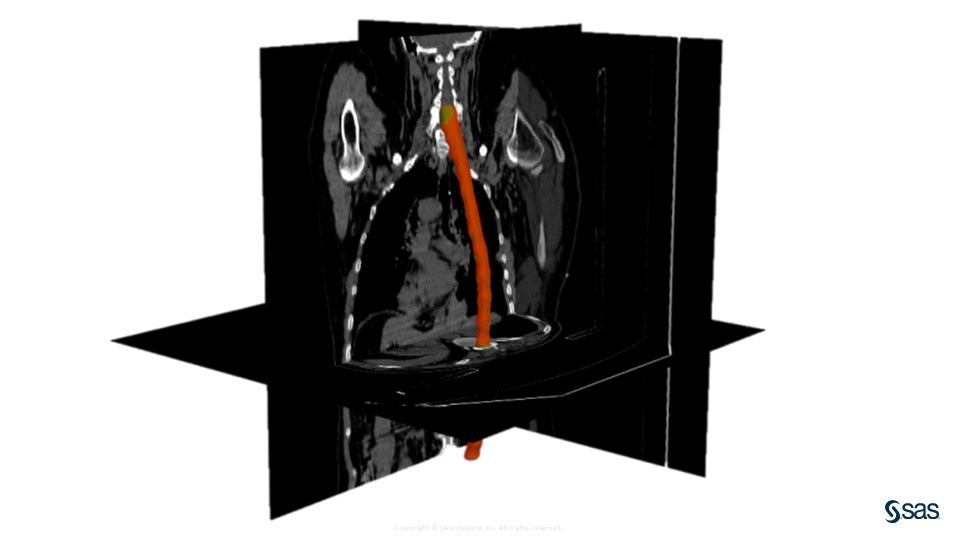

In [33]:
s.image.fetchImages(imageTable = 'slides').Images.Image[7]

NOTE: Table SLIDES contains decompressed images.


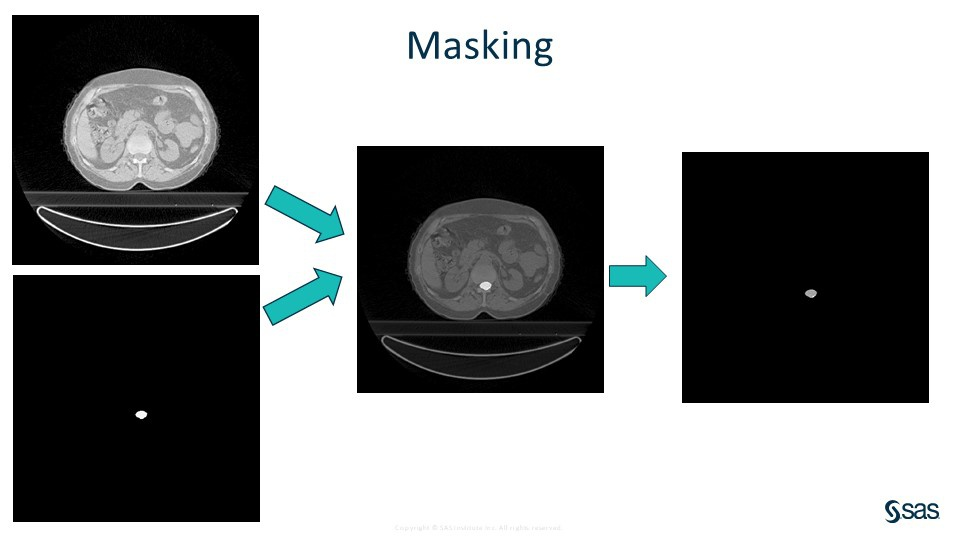

In [36]:
s.image.fetchImages(imageTable = 'slides').Images.Image[9]

### Use segmentation image to mask CT scan

In [37]:
s.fedsql.execdirect("create table q_test {options replace=true} as select * from import_images_geo")

s.table.altertable(table='q_test',
                   columns=[dict(name='_dimension_', rename='dim'),
                            dict(name='_resolution_', rename='res'),
                            dict(name='_imageformat_', rename='form'),
                            dict(name='_orientation_', rename='ori'),
                            dict(name='_position_', rename='pos'),
                            dict(name='_spacing_', rename='spa'),
                            dict(name='_image_', rename='seg')])

jdata = s.CASTable('jdata')

s.fedsql.execdirect("""create table jdata {options replace=true} as select a.*, b._image_ from q_test as a 
                    inner join final_testim as b on a._label_=b._label_ """)

bdata = s.CASTable('bdata', replace=True)

s.biomedimage.processbiomedimages(
    images=dict(
        table=jdata, dimension='dim', resolution='res', imageformat='form'),
    steps=[dict(stepparameters=dict(
                steptype='binary_operation',
                binaryoperation=dict(
                    binaryoperationtype='mask_specific',
                    image='seg',
                    dimension='dim', 
                    resolution='res', 
                    imageformat='form',
                    outputBackground=-1000
                )))],
    casout=bdata,
    decode=True,
    addcolumns=['channeltype', 'position', 'orientation', 'spacing', 'width', 'height', 'depth'],
    copyVars=['_id_', '_label_'],
)

NOTE: Table Q_TEST was created in caslib CASUSER(coambr) with 17 rows returned.
NOTE: Table JDATA was created in caslib CASUSER(coambr) with 17 rows returned.
NOTE: Processed 17 images from Cloud Analytic Services table JDATA.


,casLib,Name,Label,Rows,Columns,casTable
0,CASUSER(coambr),bdata,,17,14,"CASTable('bdata', caslib='CASUSER(coambr)')"


### Quantify data

In [38]:
vol = s.CASTable(name='vol', replace=True)

s.biomedimage.quantifybiomedimages(images=dict(table='bdata'),
                                   quantities=[dict(quantityparameters=dict(quantitytype='content',usespacing=True)),
                                               dict(quantityparameters=dict(quantitytype='mean')),
                                               dict(quantityparameters=dict(quantitytype='maximum')),
                                               dict(quantityparameters=dict(quantitytype='minimum'))],
                                   inputbackground=0,
                                   labelParameters=dict(labelType='basic', connectivity='vertex'),
                                   region='image',
                                   copyvars=['_id_', '_label_'],
                                   casout=vol)
vol.to_frame()

NOTE: Processed 17 images from Cloud Analytic Services table BDATA.


,_imageId_,_content_,_mean_,_maximum_,_minimum_,_id_,_label_
0,1116,11234.0,0.173480,216.0,0.0,1116,LCTSC-Test-S2-102
1,683,6235.0,0.060584,118.0,0.0,683,LCTSC-Test-S1-201
2,7834,4056.0,0.016881,114.0,0.0,7834,LCTSC-Test-S3-103
3,954,7817.0,0.069760,119.0,0.0,954,LCTSC-Test-S1-204
4,7835,6082.0,0.048763,103.0,0.0,7835,LCTSC-Test-S3-104
5,2370,418.0,0.034152,86.0,0.0,2370,LCTSC-Test-S3-203
6,1575,2414.0,0.020001,33.0,0.0,1575,LCTSC-Test-S2-202
7,1718,6629.0,0.148444,222.0,0.0,1718,LCTSC-Test-S2-203
8,2576,31992.0,0.050063,118.0,0.0,2576,LCTSC-Test-S3-204
9,8185,452.0,0.017261,102.0,0.0,8185,LCTSC-Test-S3-201


### Import ground truth, mask, and quantify 

In [39]:
test_import = s.CASTable('test_import', replace=True)
s.biomedimage.processbiomedimages(
    images=dict(table=dict(name="test"), image='seg'),
    steps=[dict(stepparameters=dict(steptype='import',targetDimension=3))],
    decode=True,
    copyVars=['_id_', '_label_'],
    addColumns=['width', 'height', 'depth', 'channeltype', 'spacing', 'position', 'orientation'],
    casout=test_import
)

s.fedsql.execdirect("create table q_test_gt {options replace=true} as select * from test_import")

s.table.altertable(table='q_test_gt',
                   columns=[dict(name='_dimension_', rename='dim'),
                            dict(name='_resolution_', rename='res'),
                            dict(name='_imageformat_', rename='form'),
                            dict(name='_orientation_', rename='ori'),
                            dict(name='_position_', rename='pos'),
                            dict(name='_spacing_', rename='spa'),
                            dict(name='_image_', rename='seg')])

jdata_gt = s.CASTable('jdata_gt')

s.fedsql.execdirect("""create table jdata_gt {options replace=true} as select a.*, b._image_ from 
                       q_test_gt as a inner join final_testim as b on a._label_=b._label_ """)

bdata_gt = s.CASTable('bdata_gt', replace=True)

s.biomedimage.processbiomedimages(
    images=dict(
        table=jdata_gt, dimension='dim', resolution='res', imageformat='form'),
    steps=[dict(stepparameters=dict(
                steptype='binary_operation',
                binaryoperation=dict(
                    binaryoperationtype='mask_specific',
                    image='seg',
                    dimension='dim', 
                    resolution='res', 
                    imageformat='form',
                    outputBackground=-1000
                )))],
    casout=bdata_gt,
    decode=True,
    addcolumns=['position', 'orientation', 'spacing', 'channeltype', 'width', 'height', 'depth'],
    copyVars=['_id_', '_label_'],
)

vol_orig = s.CASTable(name='vol_orig', replace=True)

s.biomedimage.quantifyBioMedImages(
    images=dict(table='bdata_gt'),
    region='image',
    quantities=[dict(quantityparameters=dict(quantitytype='CONTENT',usespacing=True)),
                dict(quantityparameters=dict(quantitytype='MEAN')),
                dict(quantityparameters=dict(quantitytype='MAXIMUM')),
                dict(quantityparameters=dict(quantitytype='MINIMUM')),
    ],
    inputbackground=0,
    labelParameters=dict(labelType='basic', connectivity='vertex'),
    copyvars=['_label_', '_id_'],
    casout=vol_orig)

NOTE: Processed 634 images from Cloud Analytic Services table TEST.
NOTE: Table Q_TEST_GT was created in caslib CASUSER(coambr) with 17 rows returned.
NOTE: Table JDATA_GT was created in caslib CASUSER(coambr) with 17 rows returned.
NOTE: Processed 17 images from Cloud Analytic Services table JDATA_GT.
NOTE: Processed 17 images from Cloud Analytic Services table BDATA_GT.


,casLib,Name,Label,Rows,Columns,casTable
0,CASUSER(coambr),vol_orig,,17,7,"CASTable('vol_orig', caslib='CASUSER(coambr)')"


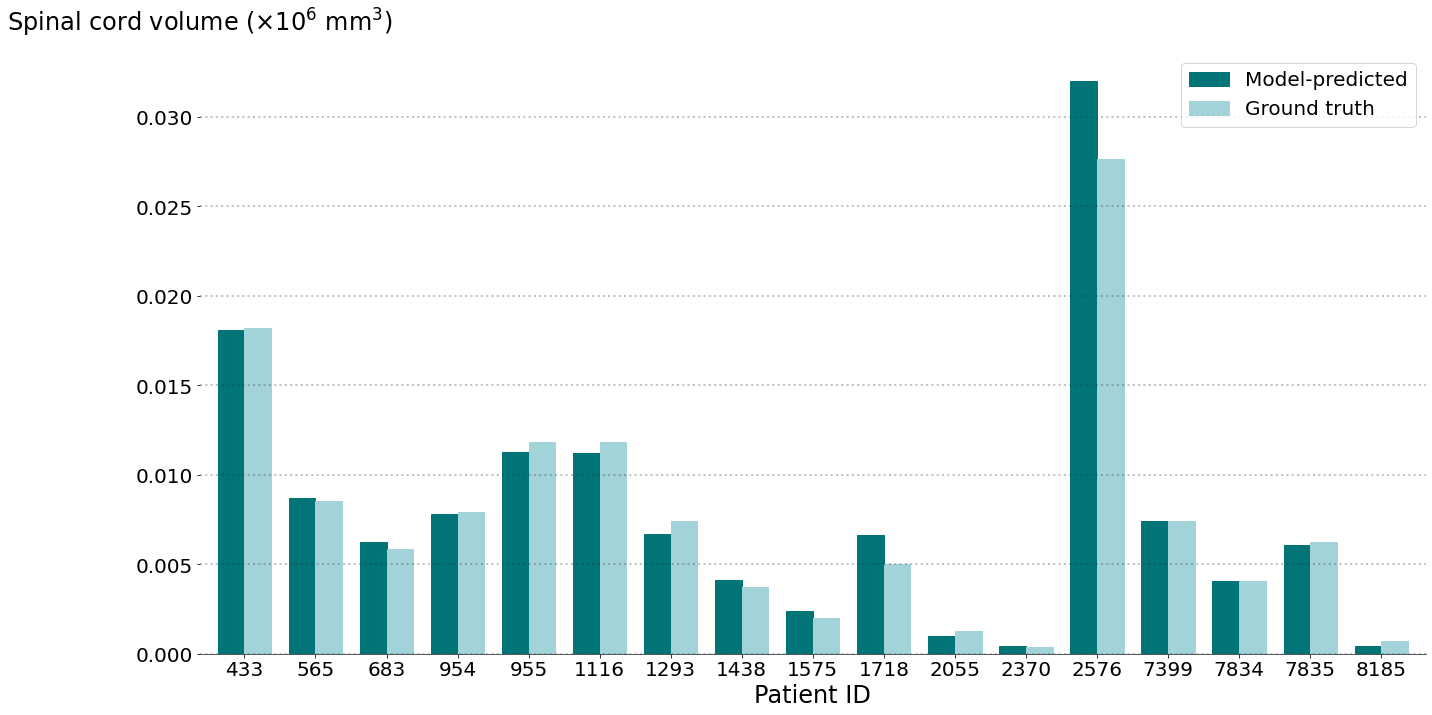

In [40]:
plot_volumes_with_ground_truth_sc(vol, vol_orig)

NOTE: Table SLIDES contains decompressed images.


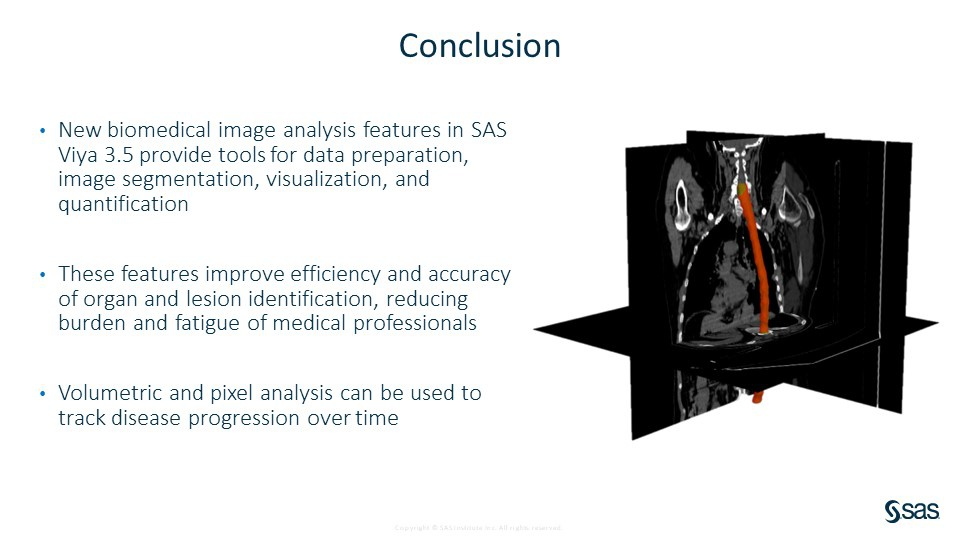

In [42]:
s.image.fetchImages(imageTable = 'slides').Images.Image[11]